# HEOM Tutorial 2: Computing Spectra

This tutorial demonstrates how to compute the dynamics of a 2-level quantum system interacting with a bath. The formalism for this is the Hierarchy of Equations of Motion (HEOM).


In [32]:
import cmath
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py import data_read
import libra_py.dynamics.heom.compute as compute
from libra_py import ft


plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

In [37]:
# Some reasonable values
Omega = 0.1 * units.ev2Ha
J = 0.05 * units.ev2Ha


Ham = CMATRIX(3,3)
Ham.set(0, 0, 0.0+0.0j);  Ham.set(0, 1,  0.0+0.0j );          Ham.set(0, 2,  0.0+0.0j );
Ham.set(1, 0, 0.0+0.0j);  Ham.set(1, 1,  Omega*(1.0+0.0j) );  Ham.set(1, 2,  -J*(1.0+0.0j) );
Ham.set(2, 0, 0.0+0.0j);  Ham.set(2, 1,  -J*(1.0+0.0j) );     Ham.set(2, 2,  Omega*(1.0+0.0j) );


rho = CMATRIX(3,3)
rho.set(1, 1, 1.0+0.0j) 


# 0.1*units.fs2au
# 

params = { "KK":3, "LL":5, 
           "gamma": 0.3 * J,
           "eta": 4.0 * J,
           "temperature": (J/(5.0*units.kB)),
           "el_phon_couplings":initialize_el_phonon_couplings(3),

           "dt":0.05, "nsteps":1000, 
           "verbosity":-1, "progress_frequency":0.1,

           "do_truncate":1, "do_scale":1,
           "tolerance":1e-5, "filter_after_steps":1,
           "num_threads":4,

           "prefix":"out", 
           "hdf5_output_level":0, "txt_output_level":0, "mem_output_level":3,
           "properties_to_save": [ "timestep", "time", "denmat"],
           "use_compression":0, "compression_level":[0,0,0]
         }

compute.run_dynamics(params, Ham, rho)

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
Calculations took 243.69574809074402 seconds
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'denmat']
keywords =  ['timestep', 'time', 'denmat']
keys =  dict_keys(['timestep', 'time', 'denmat'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named denmat/data


Print the computed results ( in the out/mem_data.hdf) as well as the reference results (in the rho.out file)

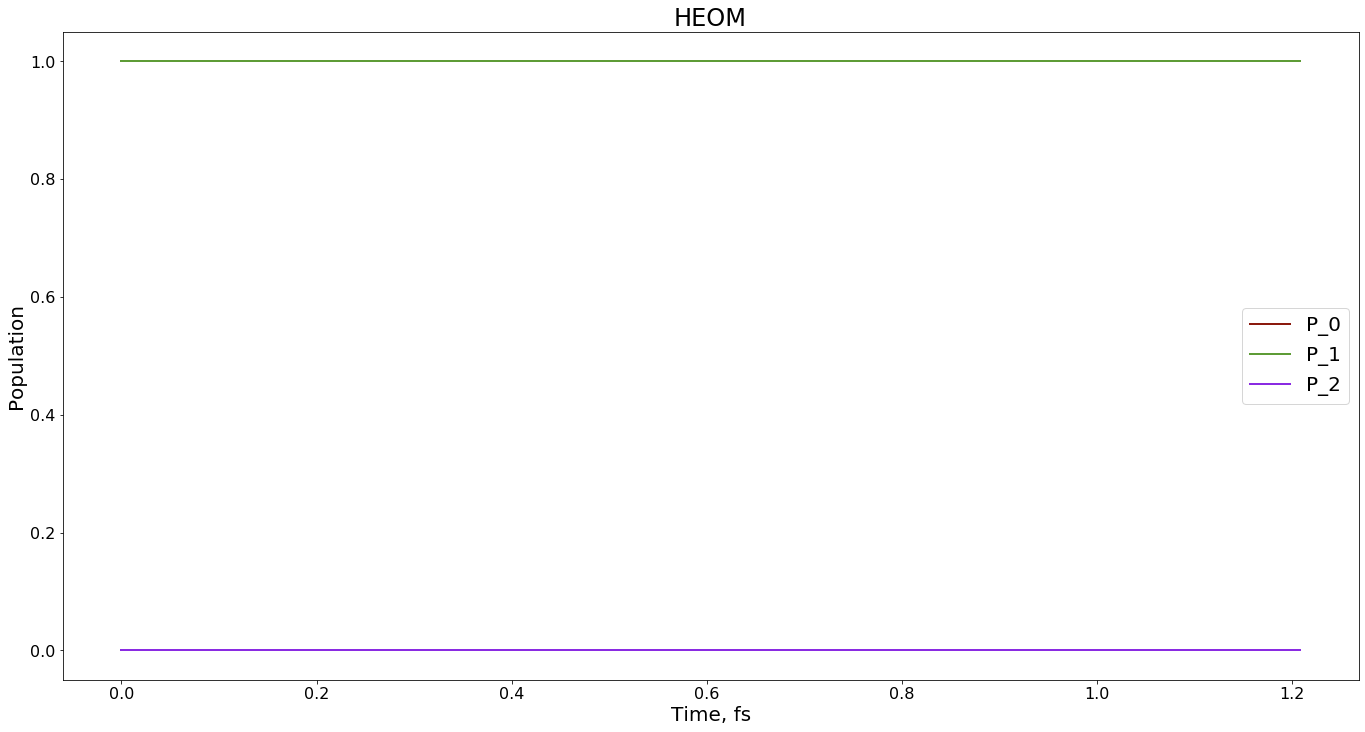

In [38]:
lib = [ None, None, None, None ]

with h5py.File(F"out/mem_data.hdf", 'r') as f:
    lib[0] = list(f["time/data"][:] * units.au2fs)
    lib[1] = list(f["denmat/data"][:, 0,0])
    lib[2] = list(f["denmat/data"][:, 1,1])
    lib[3] = list(f["denmat/data"][:, 2,2])

    
plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('HEOM')
plt.xlabel('Time, fs')
plt.ylabel('Population')
plt.plot(lib[0], lib[1], label='P_0', linewidth=2, color = colors["11"]) 
plt.plot(lib[0], lib[2], label='P_1', linewidth=2, color = colors["21"]) 
plt.plot(lib[0], lib[3], label='P_2', linewidth=2, color = colors["31"]) 
plt.legend()
plt.show()
plt.close()


We are now ready to compute the ACF of the system's dipole moment operator. 
In this type of calculations, one defines the initial values of the transition dipole matrix.
The time-evolution is described via the rho which is already printed in the file.

In this case, we just look at a 2-level example

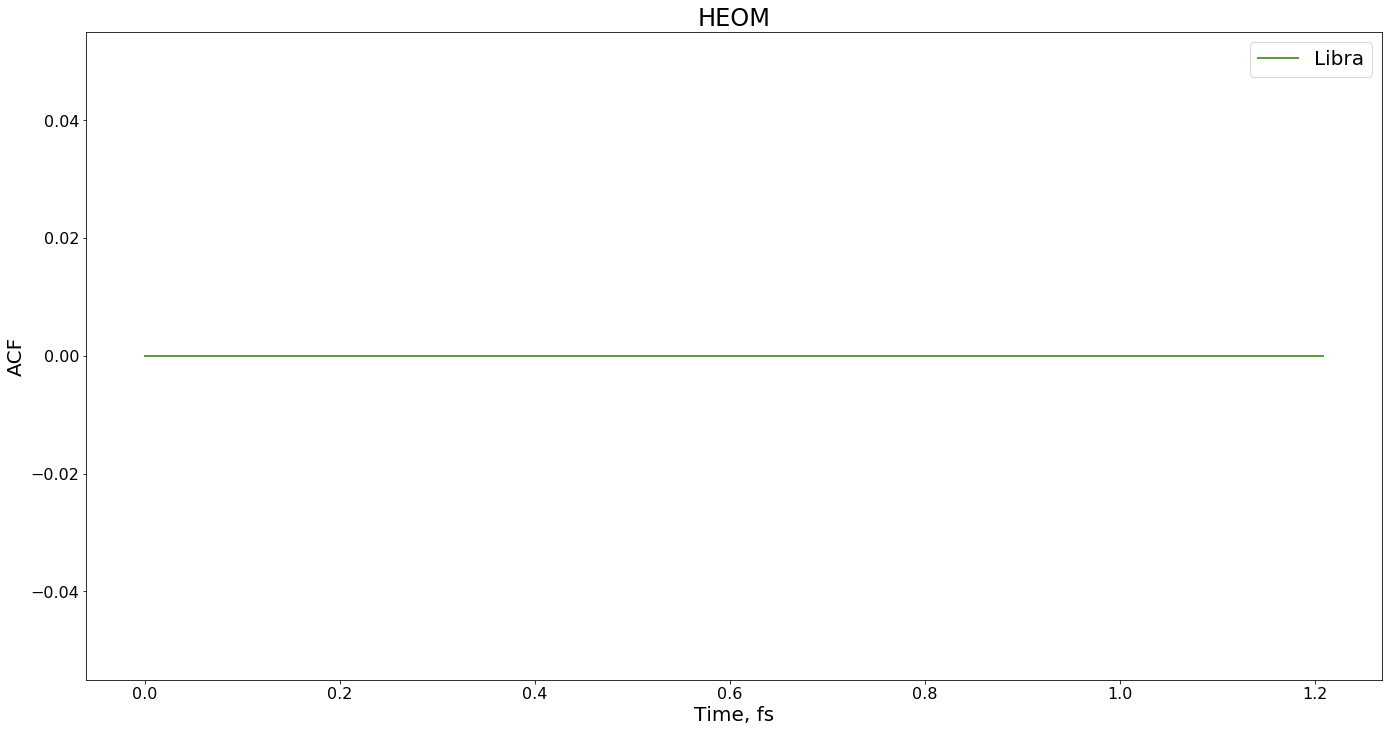

In [39]:
mu = CMATRIX(3,3)
mu.set(0,0, 0.0+0.0j);  mu.set(0,1, 1.0+0.0j);   mu.set(0,2, 1.0+0.0j); 
mu.set(1,0, 1.0+0.0j);  mu.set(1,1, 0.0+0.0j);   mu.set(1,2, 0.0+0.0j); 
mu.set(2,0, 1.0+0.0j);  mu.set(2,1, 0.0+0.0j);   mu.set(2,2, 0.0+0.0j); 


with h5py.File(F"out/mem_data.hdf", 'r') as f:
    lib[0] = list(f["time/data"][:] * units.au2fs)
    
    
    nsteps = f["denmat/data"].shape[0]
    acf = []
    
    rho = CMATRIX(3,3)
    
    for step in range(nsteps):
        
        for i in range(f["denmat/data"].shape[1]):
            for j in range(f["denmat/data"].shape[2]):
                rho.set(i,j, f["denmat/data"][step, i,j] )
                
        ct = (mu * rho).tr().real
        acf.append(ct)
       
    
plt.figure(2, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('HEOM')
plt.xlabel('Time, fs')
plt.ylabel('ACF')
plt.plot(lib[0], acf, label='Libra', linewidth=2, color = colors["21"]) 
plt.legend()
plt.show()
plt.close()

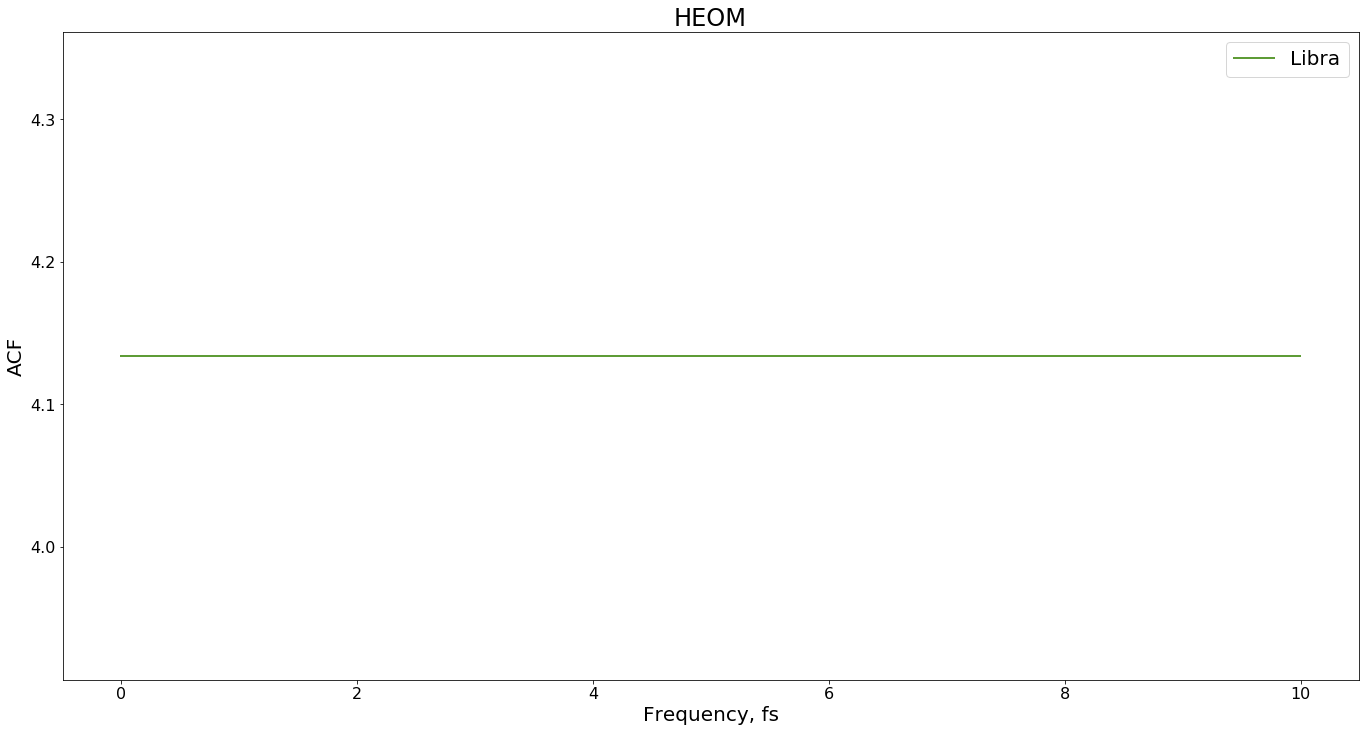

In [36]:
wspan = 10.0
dw = 0.01
dt = 0.1*units.fs2au

W, J = ft.ft(acf, wspan, dw, dt)
#W, C, S = ft.py_cft(acf, dt)

plt.figure(3, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('HEOM')
plt.xlabel('Frequency, fs')
plt.ylabel('ACF')
plt.plot(W, J, label='Libra', linewidth=2, color = colors["21"]) 
plt.legend()
plt.show()
plt.close()